<a href="https://colab.research.google.com/github/cxbxmxcx/EvolutionaryDeepLearning/blob/main/EDL_4_1_GP_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original Source: https://github.com/DEAP/deap/blob/master/examples/ga/onemax_numpy.py

DEAP is free software: you can redistribute it and/or modify
   it under the terms of the GNU Lesser General Public License as
   published by the Free Software Foundation, either version 3 of
   the License, or (at your option) any later version.

   DEAP is distributed in the hope that it will be useful,
   but WITHOUT ANY WARRANTY; without even the implied warranty of
   MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
   GNU Lesser General Public License for more details.
   You should have received a copy of the GNU Lesser General Public
   License along with DEAP. If not, see <http://www.gnu.org/licenses/>.

In [1]:
#@title Install DEAP
!pip install deap --quiet

     |████████████████████████████████| 160 kB 888 kB/s 


In [2]:
#@title Imports
import operator
import math
import random

import numpy as np

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

In [3]:
#@title Protected Division to avoid errors
random.seed(64)
def protectedDiv(left, right):
    with np.errstate(divide='ignore',invalid='ignore'):
        x = np.divide(left, right)
        if isinstance(x, np.ndarray):
            x[np.isinf(x)] = 1
            x[np.isnan(x)] = 1
        elif np.isinf(x) or np.isnan(x):
            x = 1
    return x

In [4]:
#@title Use Boston Housing dataset as input
from sklearn.datasets import load_boston
x, y = load_boston(return_X_y=True)
X = np.swapaxes(x,0,1)
inputs = X.shape[0]

# **Boston Housing Features**
* CRIM: Per capita crime rate by town
* ZN: Proportion of residential land zoned for lots over 25,000 sq. ft
* INDUS: Proportion of non-retail business acres per town
* CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
* NOX: Nitric oxide concentration (parts per 10 million)
* RM: Average number of rooms per dwelling
* AGE: Proportion of owner-occupied units built prior to 1940
* DIS: Weighted distances to five Boston employment centers
* RAD: Index of accessibility to radial highways
* TAX: Full-value property tax rate per $10,000

* PTRATIO: Pupil-teacher ratio by town
* B: 1000(Bk — 0.63)², where Bk is the proportion of [people of African American descent] by town
* LSTAT: Percentage of lower status of the population
* TARGET = MEDV: Median value of owner-occupied homes in $1000s


In [5]:
#@title Code to Inspect Dataset
import pandas as pd
boston_dataset = load_boston()
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston['MEDV'] = boston_dataset.target
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [6]:
#@title Create Set of Operators
pset = gp.PrimitiveSet("MAIN", inputs)
pset.addPrimitive(np.add, 2, name="vadd")
pset.addPrimitive(np.subtract, 2, name="vsub")
pset.addPrimitive(np.multiply, 2, name="vmul")
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(np.negative, 1, name="vneg")
pset.addPrimitive(np.cos, 1, name="vcos")
pset.addPrimitive(np.sin, 1, name="vsin")
pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))

In [7]:
#@title Setup Fitness Criteria
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [8]:
#@title Open the Toolbox
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [9]:
#@title Define a Fitness/Evaluation Function
def evalSymbReg(individual):  
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)    
    # Evaluate the sum of squared difference between the expression      
    diff = math.sqrt(np.sum((func(*X.tolist()) - y)**2)) # unfold list of inputs x using *
    return diff,

In [10]:
#@title Add Genetic Operators to Toolbox
toolbox.register("evaluate", evalSymbReg)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register('mutate', gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

In [11]:
#@title Code to Plot the Expression Tree
import matplotlib.pyplot as plt
import networkx as nx

def plot_expression(individual):
  options = {"node_size": 500, "alpha": 0.8}
  nodes, edges, labels = gp.graph(individual)

  g = nx.Graph()
  g.add_nodes_from(nodes)
  g.add_edges_from(edges)
  
  pos = nx.spring_layout(g)  
  nx.draw_networkx_nodes(g, pos, **options)
  nx.draw_networkx_edges(g, pos, width=1.0, alpha=0.5)
  nx.draw_networkx_labels(g, pos, labels, font_size=9, font_color='k')  
  plt.show()

In [12]:
#@title Defining the Evolution Function
def eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=None, halloffame=None):  
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)    
    print(logbook.stream)
    done = False

    # Begin the generational process
    for gen in range(1, ngen + 1):
        if done: return
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        offspring = [toolbox.clone(ind) for ind in offspring]

        # Apply crossover and mutation on the offspring
        for i in range(1, len(offspring), 2):
            if random.random() < cxpb:
                offspring[i - 1], offspring[i] = toolbox.mate(offspring[i - 1],
                                                              offspring[i])
                del offspring[i - 1].fitness.values, offspring[i].fitness.values

        for i in range(len(offspring)):
            if random.random() < mutpb:
                offspring[i], = toolbox.mutate(offspring[i])
                del offspring[i].fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit  
            if fit[0] <= 135:
              print("Solved")
              done = True

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)            
            plot_expression(halloffame[0])  
            print(halloffame[0]) 
            func = toolbox.compile(expr=halloffame[0]) 
            rows = x.shape[0]
            random_indices = np.random.choice(rows, size=1, replace=False)
            rd = x[random_indices, :] 
            test = func(*rd[0].tolist()) 
            print(test)   

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        print(logbook.stream)     

gen	nevals	avg   	std        	min    	max        
0  	10000 	559364	2.52076e+07	189.713	1.85702e+09


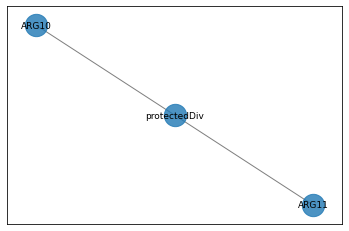

protectedDiv(ARG11, ARG10)
20.249999999999996
1  	5501  	6716.07	173534     	189.713	1.00861e+07


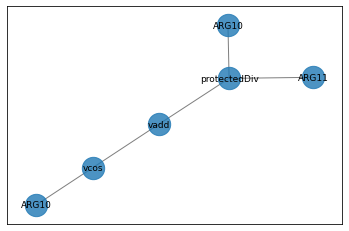

vadd(vcos(ARG10), protectedDiv(ARG11, ARG10))
24.816394595936288
2  	5617  	6951.6 	284901     	188.051	2.58269e+07


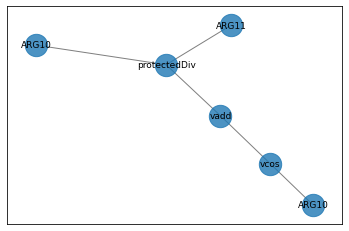

vadd(vcos(ARG10), protectedDiv(ARG11, ARG10))
29.119275855342273
3  	5511  	11357.3	631823     	188.051	5.89109e+07


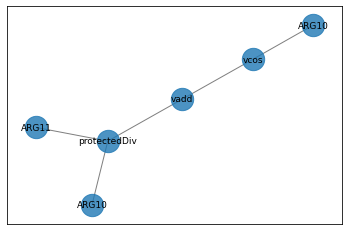

vadd(vcos(ARG10), protectedDiv(ARG11, ARG10))
19.325504060854566
4  	5387  	12508.6	1.01695e+06	188.051	1.01558e+08


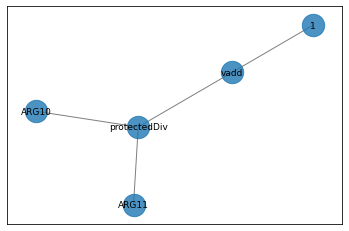

vadd(1, protectedDiv(ARG11, ARG10))
20.693193717277484
5  	5425  	12148.9	662976     	183.479	5.23608e+07


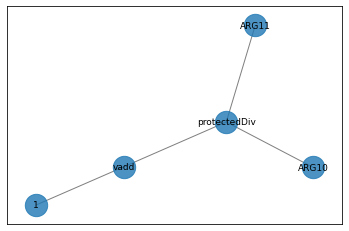

vadd(1, protectedDiv(ARG11, ARG10))
27.50408163265306
6  	5492  	6132.35	287519     	183.479	2.53524e+07


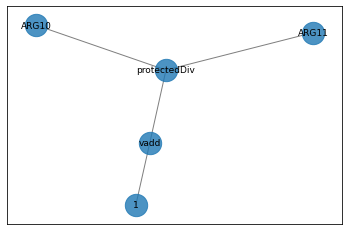

vadd(1, protectedDiv(ARG11, ARG10))
23.45481927710843
7  	5556  	35159.4	2.78946e+06	183.479	2.7311e+08 


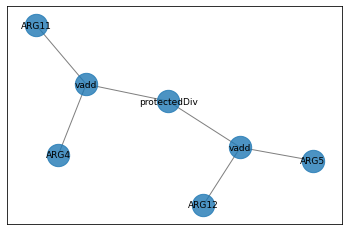

protectedDiv(vadd(ARG4, ARG11), vadd(ARG12, ARG5))
17.31279849274854
8  	5466  	55626.1	4.97066e+06	151.829	4.95822e+08


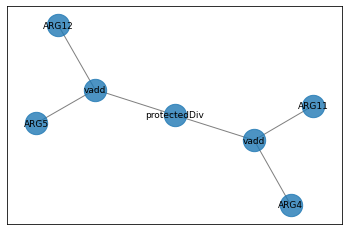

protectedDiv(vadd(ARG4, ARG11), vadd(ARG12, ARG5))
10.524507042253521
9  	5578  	9404.85	558439     	174.878	5.41715e+07


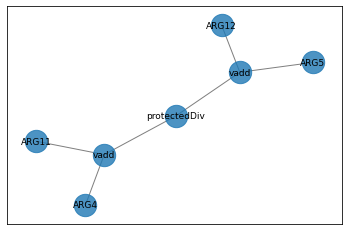

protectedDiv(vadd(ARG4, ARG11), vadd(ARG12, ARG5))
33.82567049808429
10 	5488  	10414.9	677080     	174.878	6.70729e+07


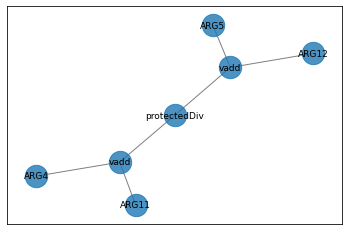

protectedDiv(vadd(ARG4, ARG11), vadd(ARG12, ARG5))
23.54042374407298
11 	5420  	10710.6	641605     	174.878	6.32365e+07


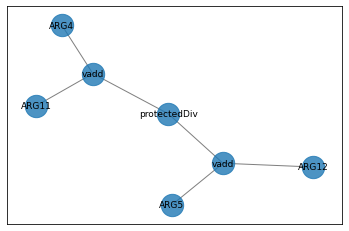

protectedDiv(vadd(ARG4, ARG11), vadd(ARG12, ARG5))
36.10496494766157
12 	5538  	5140.56	84724.7    	163.301	3.44351e+06


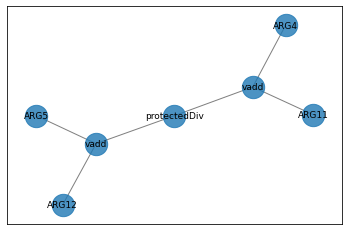

protectedDiv(vadd(ARG4, ARG11), vadd(ARG12, ARG5))
35.565458612975384
13 	5673  	5111.98	145749     	163.301	1.11278e+07


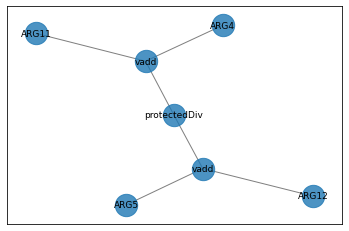

protectedDiv(vadd(ARG4, ARG11), vadd(ARG12, ARG5))
0.44797086368366285
14 	5564  	17301.8	1.09178e+06	155.553	1.08209e+08


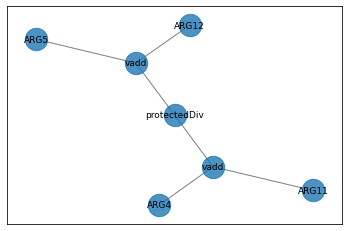

protectedDiv(vadd(ARG4, ARG11), vadd(ARG12, ARG5))
35.75617655223466
15 	5499  	12281.8	698505     	153.355	6.85477e+07


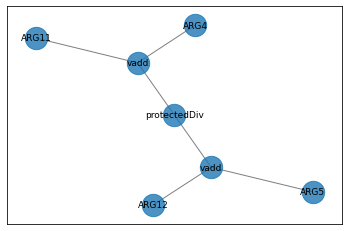

protectedDiv(vadd(ARG4, ARG11), vadd(ARG12, ARG5))
34.952406087798
16 	5457  	31371.4	1.63694e+06	153.355	1.48728e+08


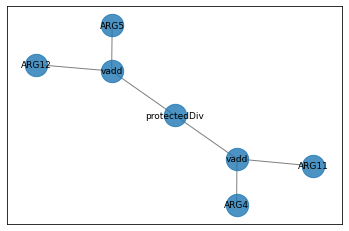

protectedDiv(vadd(ARG4, ARG11), vadd(ARG12, ARG5))
17.644331315354982
17 	5493  	70972.6	3.48278e+06	153.355	2.48576e+08


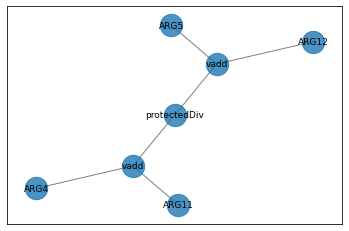

protectedDiv(vadd(ARG4, ARG11), vadd(ARG12, ARG5))
31.945415022945014
18 	5529  	92058.4	6.24557e+06	151.91 	5.64439e+08


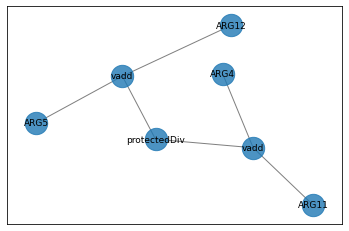

protectedDiv(vadd(ARG4, ARG11), vadd(ARG12, ARG5))
18.745788964181994
19 	5490  	39108.5	2.76272e+06	151.91 	2.6608e+08 


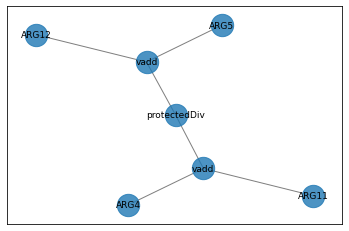

protectedDiv(vadd(ARG4, ARG11), vadd(ARG12, ARG5))
18.225300431153105
20 	5567  	122478 	1.1345e+07 	151.91 	1.13375e+09


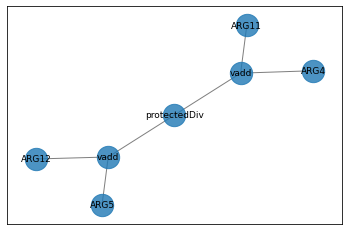

protectedDiv(vadd(ARG4, ARG11), vadd(ARG12, ARG5))
23.29359837419027
21 	5482  	137356 	7.00471e+06	151.91 	4.97779e+08


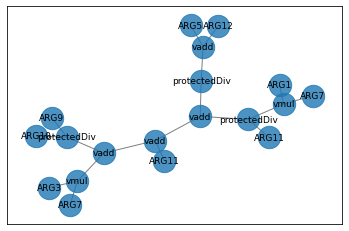

protectedDiv(vadd(protectedDiv(ARG11, vmul(ARG7, ARG1)), vadd(vadd(vmul(ARG7, ARG3), protectedDiv(ARG9, ARG10)), ARG11)), vadd(ARG12, ARG5))
13.14495654486349
22 	5587  	15170.9	790690     	150.377	7.55556e+07


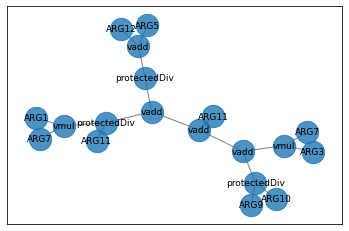

protectedDiv(vadd(protectedDiv(ARG11, vmul(ARG7, ARG1)), vadd(vadd(vmul(ARG7, ARG3), protectedDiv(ARG9, ARG10)), ARG11)), vadd(ARG12, ARG5))
4.8102042553163304
23 	5514  	12694.3	577562     	150.377	4.69337e+07


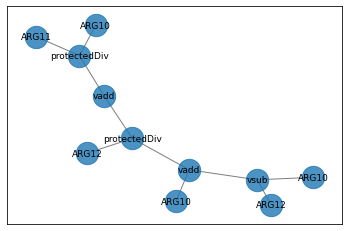

vadd(protectedDiv(ARG11, ARG10), protectedDiv(vadd(vsub(ARG10, ARG12), ARG10), ARG12))
20.920410028544513
24 	5418  	398262 	3.92203e+07	149.493	3.92214e+09


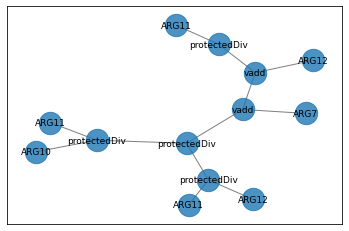

protectedDiv(ARG11, vadd(ARG12, vadd(ARG7, protectedDiv(protectedDiv(ARG11, ARG12), protectedDiv(ARG11, ARG10)))))
34.806404608270036
25 	5448  	4229.93	128738     	145.932	9.03612e+06


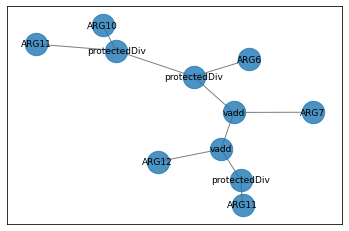

protectedDiv(ARG11, vadd(ARG12, vadd(ARG7, protectedDiv(ARG6, protectedDiv(ARG11, ARG10)))))
1.049576789657478
26 	5647  	23300.9	1.34883e+06	140.925	1.28965e+08


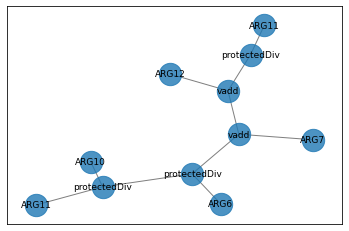

protectedDiv(ARG11, vadd(ARG12, vadd(ARG7, protectedDiv(ARG6, protectedDiv(ARG11, ARG10)))))
8.980360667067607
27 	5392  	4280.62	155871     	142.085	1.35616e+07
Solved


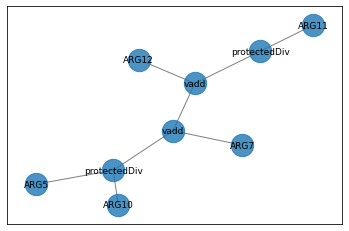

protectedDiv(ARG11, vadd(ARG12, vadd(ARG7, protectedDiv(ARG10, ARG5))))
15.083175039897414
28 	5547  	14302.6	678452     	130.48 	5.57017e+07


In [13]:
#@title Run the Evolution
pop = toolbox.population(n=10000)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

eaSimple(pop, toolbox, 0.5, 0.1, 400, stats, halloffame=hof)

